# Machine Learning for Email Spam Filter
Dataset:
Goal:
Attributes: 
    Email content
    Label(spam/ham)
Outline:

# Initial Setup

### Import Modules

In [1]:
import pandas as pd
import numpy as np
import string
import re

import nltk
from nltk.corpus import stopwords
# Import Scikit-learn helper functions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Import Scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Import Scikit-learn metric functions
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns



c:\Users\hkuspace\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Loading the dataset

In [2]:
df = pd.read_csv(r"fyp_dataset.csv",encoding='latin1')
#df.head()
df.shape

(60986, 2)

# Prepocessing




#### URL extraction


In [5]:
def url_ex(dfrow):
    url = re.findall("(http.*)\s",dfrow['body'])
    if len(url) > 0:
        dfrow['url'] = url[0]
    else:
        dfrow['url'] = None
    return dfrow

In [6]:
dfurl = df.apply(url_ex,axis=1)

#### StopWord Remove & Tokenization

In [10]:
def preprocess(body):
    #Convert to lowercase 
    lower_body = body.lower() 
    #Remove punctuation
    nonpunc = ''.join(char for char in lower_body if char not in string.punctuation)
    #Remove extra spaces
    nonspace = re.sub(r'\s+', ' ', nonpunc)
    #Remove stopwords
    clean_body = ' '.join(word for word in nonspace.split() if word not in stopwords.words('english'))
    #Tokenization
    clean_body = nltk.word_tokenize(clean_body)
    return clean_body

In [11]:
# clean the messages
dfurl['clean_body'] = dfurl['body'].apply(preprocess)

In [12]:
#Drop the null body

def drop_null(processdf):
    count = processdf['clean_body'].count()
    drop_list = []
    for i in range(count):
        blen = len(list(processdf['clean_body'])[i])
        if blen == 0:
            drop_list.append(i)
            print(i)
        else:
            pass
    return processdf.drop(drop_list)

In [13]:
df2 = drop_null(dfurl)
df2.to_csv('tocken(preprocess).csv', index=False)

11
18
19
20
25
46
51
55
64
79
91
92
106
118
122
132
134
135
163
200
207
218
283
351
352
414
415
424
426
536
541
542
547
551
555
636
668
680
694
753
795
940
960
970
1149
1241
1242
1285
1315
1350
1351
1390
1399
1447
1497
1543
1545
1611
1614
1670
1721
1824
1829
1836
1870
1874
1890
1893
1899
1977
2006
2023
2031
2113
2184
2215
2251
2275
2276
2306
2318
2326
2334
2407
2409
2413
2456
2461
2481
2513
2517
2548
2588
2640
2668
2678
2679
2680
2697
2703
2755
2757
2787
2806
2820
2836
2920
3019
3079
3142
3147
3174
3201
3218
3259
3272
3281
3284
3305
3338
3381
3412
3427
3445
3458
3475
3613
3614
3615
3631
3704
3712
3713
3746
3752
3754
3761
3807
3820
3939
3941
3942
3976
4030
4130
4150
4230
4233
4237
4264
4316
4321
4361
4384
4433
4451
4499
4502
4511
4517
4525
4582
4647
4949
4963
6499
6826
7272
7277
7282
7286
7296
7306
7330
7338
7408
7413
7429
7508
7547
7686
7693
7699
7756
7764
7768
7778
7796
7822
7864
7869
7871
7900
7909
7911
7935
7936
7966
7985
7991
8038
8043
8061
8075
8088
8111
8114
8147
8160
8249
8251
8

In [14]:
# check for null values
df2.isnull().sum()

body              0
label             0
url           30297
clean_body        0
dtype: int64

spam    39854
ham     19669
Name: label, dtype: int64


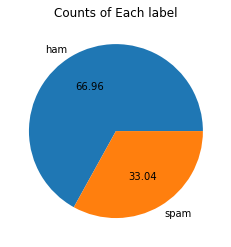

In [15]:
# Print counts of each label
print(df2['label'].value_counts())
plt.pie(df2['label'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.title('Counts of Each label')
plt.show()

# Feature Engineer

### Body Feature

### URL Feature

### Data Separate

In [ ]:
#Split Data to train &　test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['body'],df['label'],test_size=0.2, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(48788,) (12198,) (48788,) (12198,)


# Building a Vectorizer

### Vectorize the Training Data

In [ ]:
# Vectorize the training inputs -- Takes about 35 mins to complete
#   There are two types of vectors: 

#     1. Count vectorizer
print("- Training Count Vectorizer -")
countVec = CountVectorizer(tokenizer=tokenizer)
train_count_x = countVec.fit_transform(x_train)

#     2. Term Frequency-Inverse Document Frequency (TF-IDF)corpus
print("- Training TF-IDF Vectorizer -")
tfidVec = TfidfVectorizer(tokenizer=tokenizer)
train_tfidf_x = tfidVec.fit_transform(x_train)

print("\n### Vectorizing Complete ###\n")

### Vectorize the Testing Data

In [ ]:
# Vectorize the testing inputs -- Takes about 15 mins to complete

print("- Count Vectorizer -")
test_count_x = countVec.transform(x_test)

print("- Tfidf Vectorizer -")
test_tfidf_x = tfidVec.transform(x_test)

print("\n### Vectorizing Complete ###\n")

# Test and Evaluate the Models

In [ ]:
tfidf_X.toarray()[0]

array([0.36145677, 0.25514595, 0.19135947, 0.10631081, 0.06378649,
       0.31893244, 0.04252433, 0.06378649, 0.02126216, 0.29767028,
       0.02126216, 0.02126216, 0.21262163, 0.06378649, 0.3401946 ,
       0.14883514, 0.04252433, 0.02126216, 0.19135947, 0.42524326,
       0.31893244, 0.21262163, 0.02126216, 0.02126216])

In [ ]:
tfidf_X.shape

(1, 24)

In [ ]:
print(count_X,tfidf_X)

  (0, 5)	15
  (0, 1)	12
  (0, 19)	20
  (0, 20)	15
  (0, 0)	17
  (0, 9)	14
  (0, 14)	16
  (0, 6)	2
  (0, 15)	7
  (0, 12)	10
  (0, 23)	1
  (0, 8)	1
  (0, 11)	1
  (0, 21)	10
  (0, 16)	2
  (0, 18)	9
  (0, 7)	3
  (0, 22)	1
  (0, 13)	3
  (0, 2)	9
  (0, 3)	5
  (0, 4)	3
  (0, 17)	1
  (0, 10)	1   (0, 10)	0.021262162778128115
  (0, 17)	0.021262162778128115
  (0, 4)	0.06378648833438434
  (0, 3)	0.10631081389064058
  (0, 2)	0.19135946500315304
  (0, 13)	0.06378648833438434
  (0, 22)	0.021262162778128115
  (0, 7)	0.06378648833438434
  (0, 18)	0.19135946500315304
  (0, 16)	0.04252432555625623
  (0, 21)	0.21262162778128116
  (0, 11)	0.021262162778128115
  (0, 8)	0.021262162778128115
  (0, 23)	0.021262162778128115
  (0, 12)	0.21262162778128116
  (0, 15)	0.1488351394468968
  (0, 6)	0.04252432555625623
  (0, 14)	0.34019460445004984
  (0, 9)	0.2976702788937936
  (0, 0)	0.36145676722817793
  (0, 20)	0.3189324416719217
  (0, 19)	0.4252432555625623
  (0, 1)	0.25514595333753737
  (0, 5)	0.3189324416719217


In [ ]:



if __name__ == '__main__':
    df = pd.read_csv(r"trec07p1.csv",encoding='latin1')
    df.info()
    #Convert the body to a matrix of token counts trec07p1 (using function **process)
    #extract feature
    bow = CountVectorizer(analyzer=process).fit_transform(df['body'])
    print(bow.shape)

